# Dataloader Construct

In [1]:
import paddle
from paddle.io import Dataset, DataLoader, IterableDataset
import numpy as np
import cv2
import random
import time
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=Warning) # 过滤报警信息

BATCH_SIZE = 1
DATA_DIR = './data/horse2zebra/' # 设置训练集数据地址
# PLACE = paddle.CPUPlace() # 在cpu上训练
PLACE = paddle.CUDAPlace(0)  # 在gpu上训练

In [2]:
from PIL import Image
from paddle.vision.transforms import RandomCrop, CenterCrop

# 处理图片数据：随机裁切、调整图片数据形状、归一化数据
def data_transform(img, output_size=224):
    h, w, _ = img.shape
    assert h == w and h >= output_size # check picture size
    # random crop
    # c = RandomCrop(output_size)
    c = CenterCrop(output_size)
    img = c(img) # np.array
    # normalize
    img = (img / 255. - 0.5) / 0.5
    # from [H,W,C] to [C,H,W]
    img = np.transpose(img, (2, 0, 1))
    # data type
    img = img.astype('float32')    
    return img

# 定义horse2zebra数据集对象
class H2ZDateset(Dataset):
    def __init__(self, data_dir):
        super(H2ZDateset, self).__init__()
        self.data_dir = data_dir
        self.pic_list_a = np.loadtxt(data_dir+'trainA.txt', dtype=np.str)
        np.random.shuffle(self.pic_list_a)
        self.pic_list_b = np.loadtxt(data_dir+'trainB.txt', dtype=np.str)
        np.random.shuffle(self.pic_list_b)
        self.pic_list_lenth = min(int(self.pic_list_a.shape[0]), int(self.pic_list_b.shape[0]))

    def __getitem__(self, idx):
        img_dir_a = self.data_dir+self.pic_list_a[idx]
        img_a = cv2.imread(img_dir_a)
        img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
        img_a = data_transform(img_a, 224)
        img_dir_b = self.data_dir+self.pic_list_b[idx]
        img_b = cv2.imread(img_dir_b)
        img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB)
        img_b = data_transform(img_b, 224)
        return np.array([img_a, img_b])

    def __len__(self):
        return self.pic_list_lenth

In [3]:
from PIL import Image
import os

# 打开图片
def open_pic(file_name='./data/horse2zebra/testA/n02381460_1300.jpg'):
    img = Image.open(file_name).resize((256, 256), Image.BILINEAR)
    img = (np.array(img).astype('float32') / 255.0 - 0.5) / 0.5
    img = img.transpose((2, 0, 1))
    img = img.reshape((-1, img.shape[0], img.shape[1], img.shape[2]))
    return img

# 存储图片
def save_pics(pics, file_name='tmp', save_path='./output/pics/', save_root_path='./output/'):
    if not os.path.exists(save_root_path):
        os.makedirs(save_root_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for i in range(len(pics)):
        pics[i] = pics[i][0]
    pic = np.concatenate(tuple(pics), axis=2)
    pic = pic.transpose((1,2,0))
    pic = (pic + 1) / 2
    # plt.imshow(pic)
    pic = np.clip(pic * 256, 0, 255)
    img = Image.fromarray(pic.astype('uint8')).convert('RGB')
    img.save(save_path+file_name+'.jpg')
    
# 显示图片
def show_pics(pics):
    """
    pics shape: [2, B, C, H, W]
    """
    plt.figure(figsize=(3 * len(pics), 3), dpi=80)
    for i in range(len(pics)):
        pics[i] = (pics[i][0].transpose((1,2,0)) + 1) / 2
        plt.subplot(1, len(pics), i + 1)
        plt.imshow(pics[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()


In [4]:
# 定义图片loader
h2zdateset = H2ZDateset(DATA_DIR)
loader = DataLoader(h2zdateset, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, num_workers=0, use_shared_memory=False)
data = next(loader())
data = paddle.transpose(data, (1, 0, 2, 3, 4))
print("读取的数据形状：", data.shape)


import numpy as np
from paddle.io import DataLoader, Dataset

class RandomDataset(Dataset):
    def __getitem__(self, idx):
        data = np.random.random((2, 3)).astype('float32')

        return data

    def __len__(self):
        return 10

dataset = RandomDataset()
loader = DataLoader(dataset, batch_size=1)
data = next(loader())

In Paddle <= 2.0, data is in format '[Tensor(shape=(1, 2, 3), dtype=float32)]', and in Paddle >= 2.1, data is in format 'Tensor(shape=(1, 2, 3), dtype=float32)'

W0512 17:21:01.411545 31942 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.2, Runtime API Version: 11.2
W0512 17:21:01.414018 31942 device_context.cc:465] device: 0, cuDNN Version: 7.6.
W0512 17:21:01.729336 31942 device_context.h:397] WARNING: device: 0. The installed Paddle is compiled with CUDNN 8.1, but CUDNN version in your machine is 7.6, which may cause serious incompatible bug. Please recompile or reinstall Paddle with compatible CUDNN

读取的数据形状： [2, 1, 3, 224, 224]


In [5]:
img_ra = paddle.to_tensor(data[0])
img_rb = paddle.to_tensor(data[1])

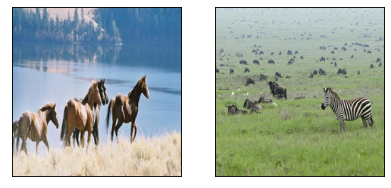

In [6]:
show_pics([img_ra, img_rb])

# Network Construct

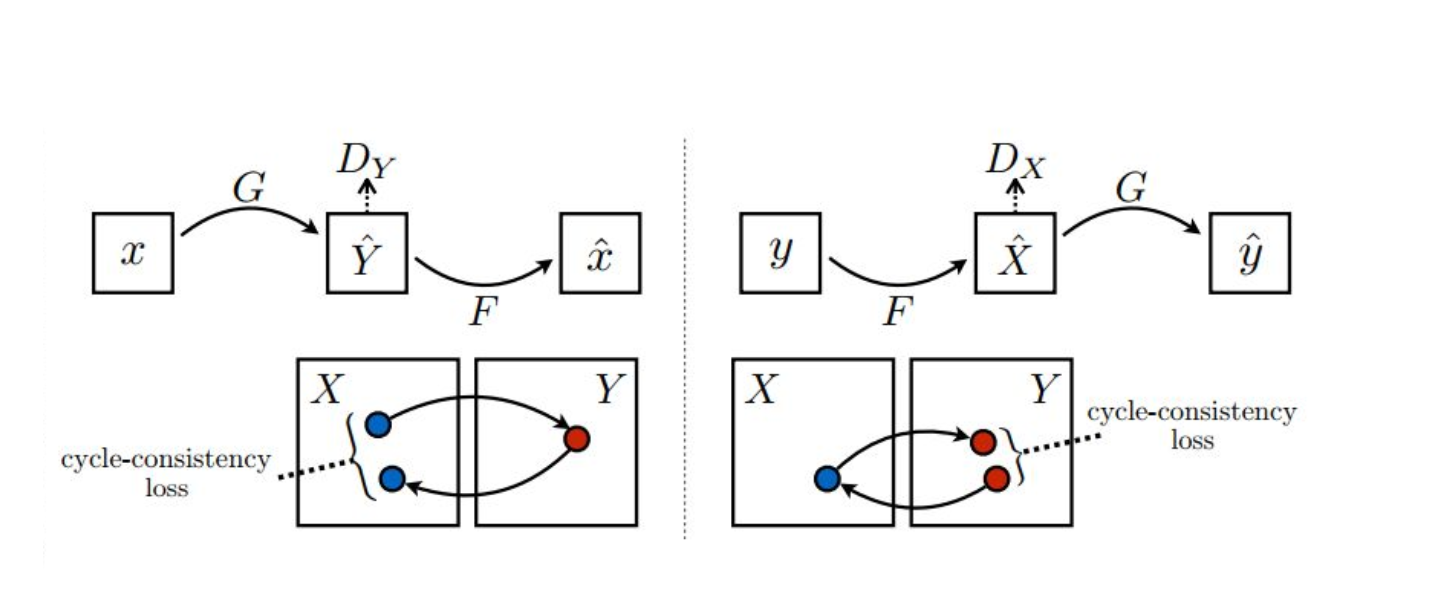

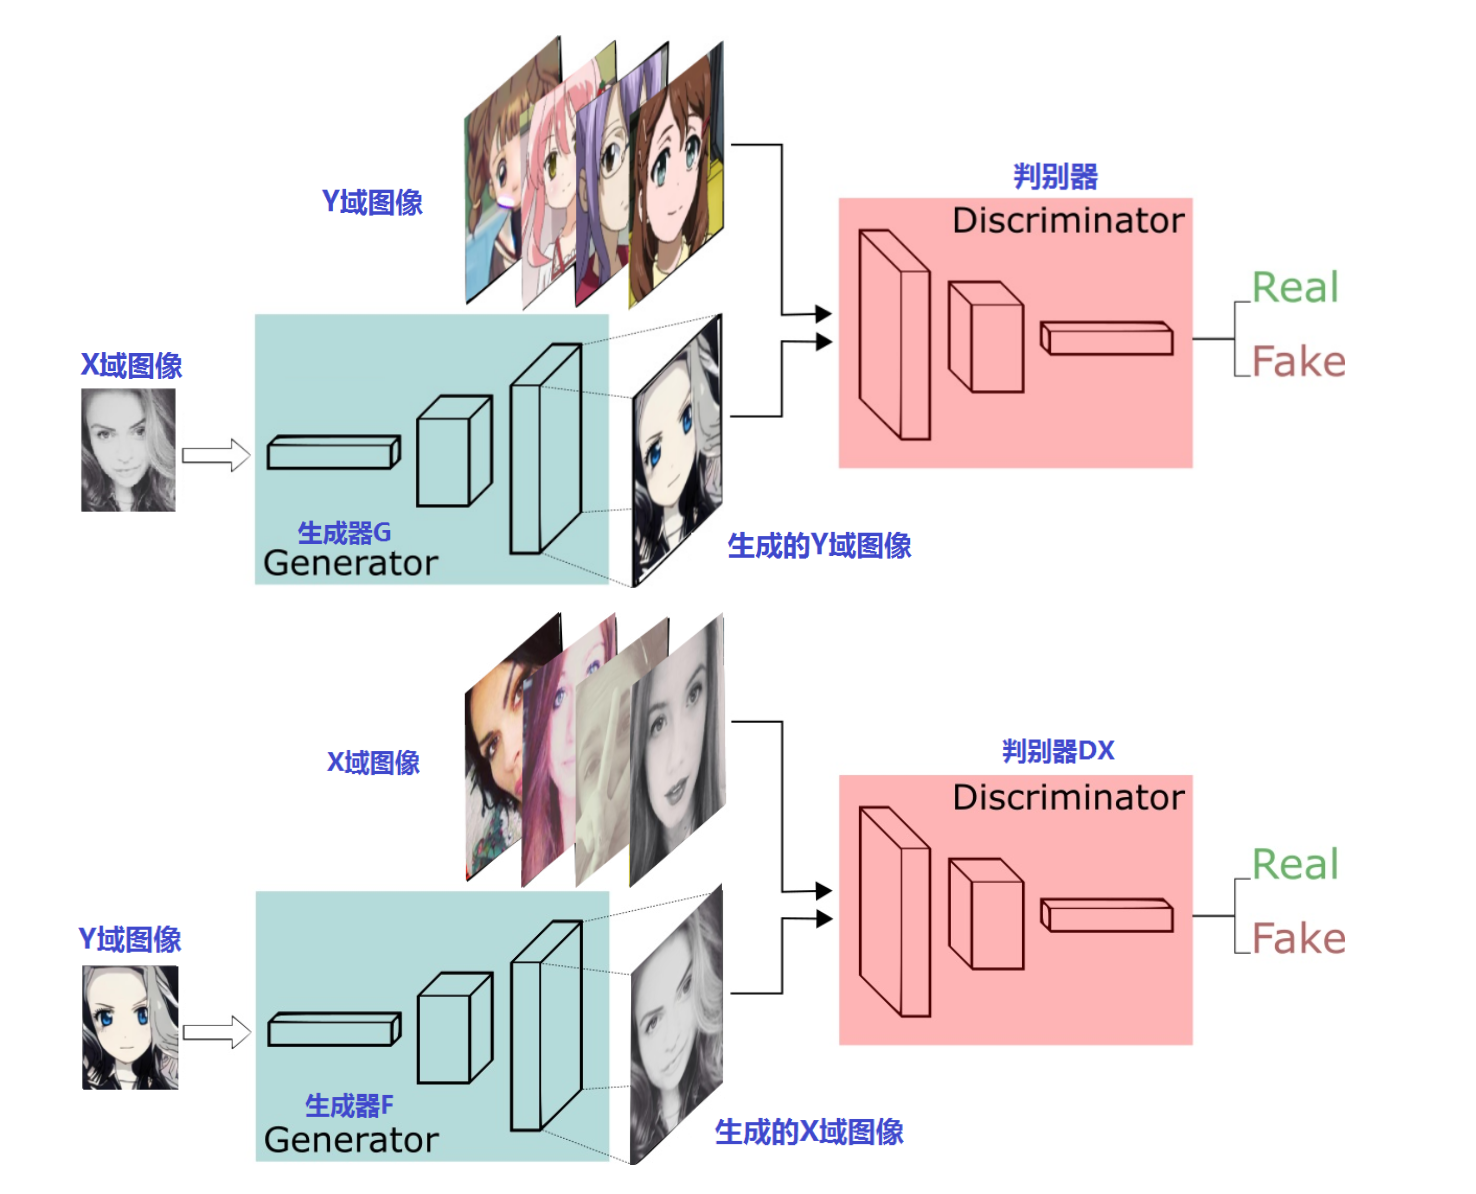

In [7]:
import paddle
import paddle.nn as nn
import numpy as np

# 定义基础的“卷积层+实例归一化”块
class ConvIN(nn.Layer):
    def __init__(self, 
                 num_channels, 
                 num_filters, 
                 filter_size, 
                 stride=1, 
                 padding=1, 
                 bias_attr=None, 
                 weight_attr=None):
        super(ConvIN, self).__init__()
        model = [
            nn.Conv2D(num_channels, 
                      num_filters, 
                      filter_size, 
                      stride=stride, 
                      padding=padding, 
                      bias_attr=bias_attr,
                      weight_attr=weight_attr),
            nn.InstanceNorm2D(num_filters),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

# 定义CycleGAN的判别器
class Disc(nn.Layer):
    def __init__(self, weight_attr=nn.initializer.Normal(0., 0.02)):
        super(Disc, self).__init__()
        model = [
            ConvIN(3, 64, 4, stride=2, padding=1, bias_attr=True, weight_attr=weight_attr),    # [B, 3, 224, 224]  -> [B, 64, 112, 112]
            ConvIN(64, 128, 4, stride=2, padding=1, bias_attr=False, weight_attr=weight_attr), # [B, 64, 112, 112] -> [B, 128, 56, 56]
            ConvIN(128, 256, 4, stride=2, padding=1, bias_attr=False, weight_attr=weight_attr),# [B, 128, 56, 56]  -> [B, 256, 28, 28]
            ConvIN(256, 512, 4, stride=1, padding=1, bias_attr=False, weight_attr=weight_attr),# [B, 256, 28, 28]  -> [B, 512, 27, 27]
            nn.Conv2D(512, 1, 4, stride=1, padding=1, bias_attr=True, weight_attr=weight_attr) # [B, 512, 27, 27]  -> [B, 1, 26, 26]
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

In [8]:
ci = ConvIN(3, 3, 3, weight_attr=nn.initializer.Normal(0., 0.02))
logit = ci(paddle.to_tensor(data[0]))
print('ConvIN块输出的特征图形状：', logit.shape)

d = Disc()
logit = d(paddle.to_tensor(data[0]))
print('判别器输出的特征图形状：', logit.shape)

ConvIN块输出的特征图形状： [1, 3, 224, 224]
判别器输出的特征图形状： [1, 1, 26, 26]


In [9]:
# 定义基础的“转置卷积层+实例归一化”块
class ConvTransIN(nn.Layer):
    def __init__(self, 
                 num_channels, 
                 num_filters, 
                 filter_size, 
                 stride=1, 
                 padding='same', 
                 bias_attr=None, 
                 weight_attr=None):
        super(ConvTransIN, self).__init__()
        model = [
            nn.Conv2DTranspose(num_channels, 
                               num_filters, 
                               filter_size, 
                               stride=stride, 
                               padding=padding, 
                               bias_attr=bias_attr, 
                               weight_attr=weight_attr),
            nn.InstanceNorm2D(num_filters),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

# 定义残差块
class Residual(nn.Layer):
    def __init__(self, dim, bias_attr=None, weight_attr=None):
        super(Residual, self).__init__()
        model = [
            nn.Conv2D(dim, dim, 3, stride=1, padding=1, padding_mode='reflect', bias_attr=bias_attr, weight_attr=weight_attr),
            nn.InstanceNorm2D(dim),
            nn.LeakyReLU(negative_slope=0.2),
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return x + self.model(x)

# 定义CycleGAN的生成器
class Gen(nn.Layer):
    def __init__(self, base_dim=64, residual_num=7, downup_layer=2, weight_attr=nn.initializer.Normal(0., 0.02)):
        super(Gen, self).__init__()
        # [B, 3, 224, 224] -> [B, 64, 224, 224]
        model=[
            nn.Conv2D(3, base_dim, 7, stride=1, padding=3, padding_mode='reflect', bias_attr=False, weight_attr=weight_attr),
            nn.InstanceNorm2D(base_dim),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        # 下采样块（down sampling）
        # [B, 64, 224, 224]  -> [B, 128, 112, 112]
        # [B, 128, 112, 112] -> [B, 256, 56, 56]
        for i in range(downup_layer):
            model += [
                ConvIN(base_dim * 2 ** i, base_dim * 2 ** (i + 1), 3, stride=2, padding=1, bias_attr=False, weight_attr=weight_attr),
            ]
        
        # 残差块（residual blocks）
        # [B, 256, 56, 56] -> [B, 256, 56, 56]
        for i in range(residual_num):
            model += [
                Residual(base_dim * 2 ** downup_layer, True, weight_attr=nn.initializer.Normal(0., 0.02))
            ]
        
        # 上采样块（up sampling）
        # [B, 256, 56, 56] -> [B, 128, 112, 112]
        # [B, 128, 112, 112] -> [B, 64, 224, 224]
        for i in range(downup_layer):
            model += [
                ConvTransIN(base_dim * 2 ** (downup_layer - i), base_dim * 2 ** (downup_layer - i - 1), 3, stride=2, padding='same', bias_attr=False, weight_attr=weight_attr),
            ]
        
        # [B, 64, 224, 224] -> [B, 3, 224, 224]
        model += [
            nn.Conv2D(base_dim, 3, 7, stride=1, padding=3, padding_mode='reflect', bias_attr=True, weight_attr=nn.initializer.Normal(0., 0.02)),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

In [10]:
cti = ConvTransIN(3, 3, 3, stride=2, padding='same', bias_attr=False, 
    weight_attr=nn.initializer.Normal(0., 0.02))
logit = cti(paddle.to_tensor(data[0]))
print('ConvTransIN块输出的特征图形状：', logit.shape)

r = Residual(3, True, weight_attr=nn.initializer.Normal(0., 0.02))
logit = r(paddle.to_tensor(data[0]))
print('Residual块输出的特征图形状：', logit.shape)

g = Gen()
logit = g(paddle.to_tensor(data[0]))
print('生成器输出的特征图形状：', logit.shape)

ConvTransIN块输出的特征图形状： [1, 3, 448, 448]
Residual块输出的特征图形状： [1, 3, 224, 224]
生成器输出的特征图形状： [1, 3, 224, 224]


# Training

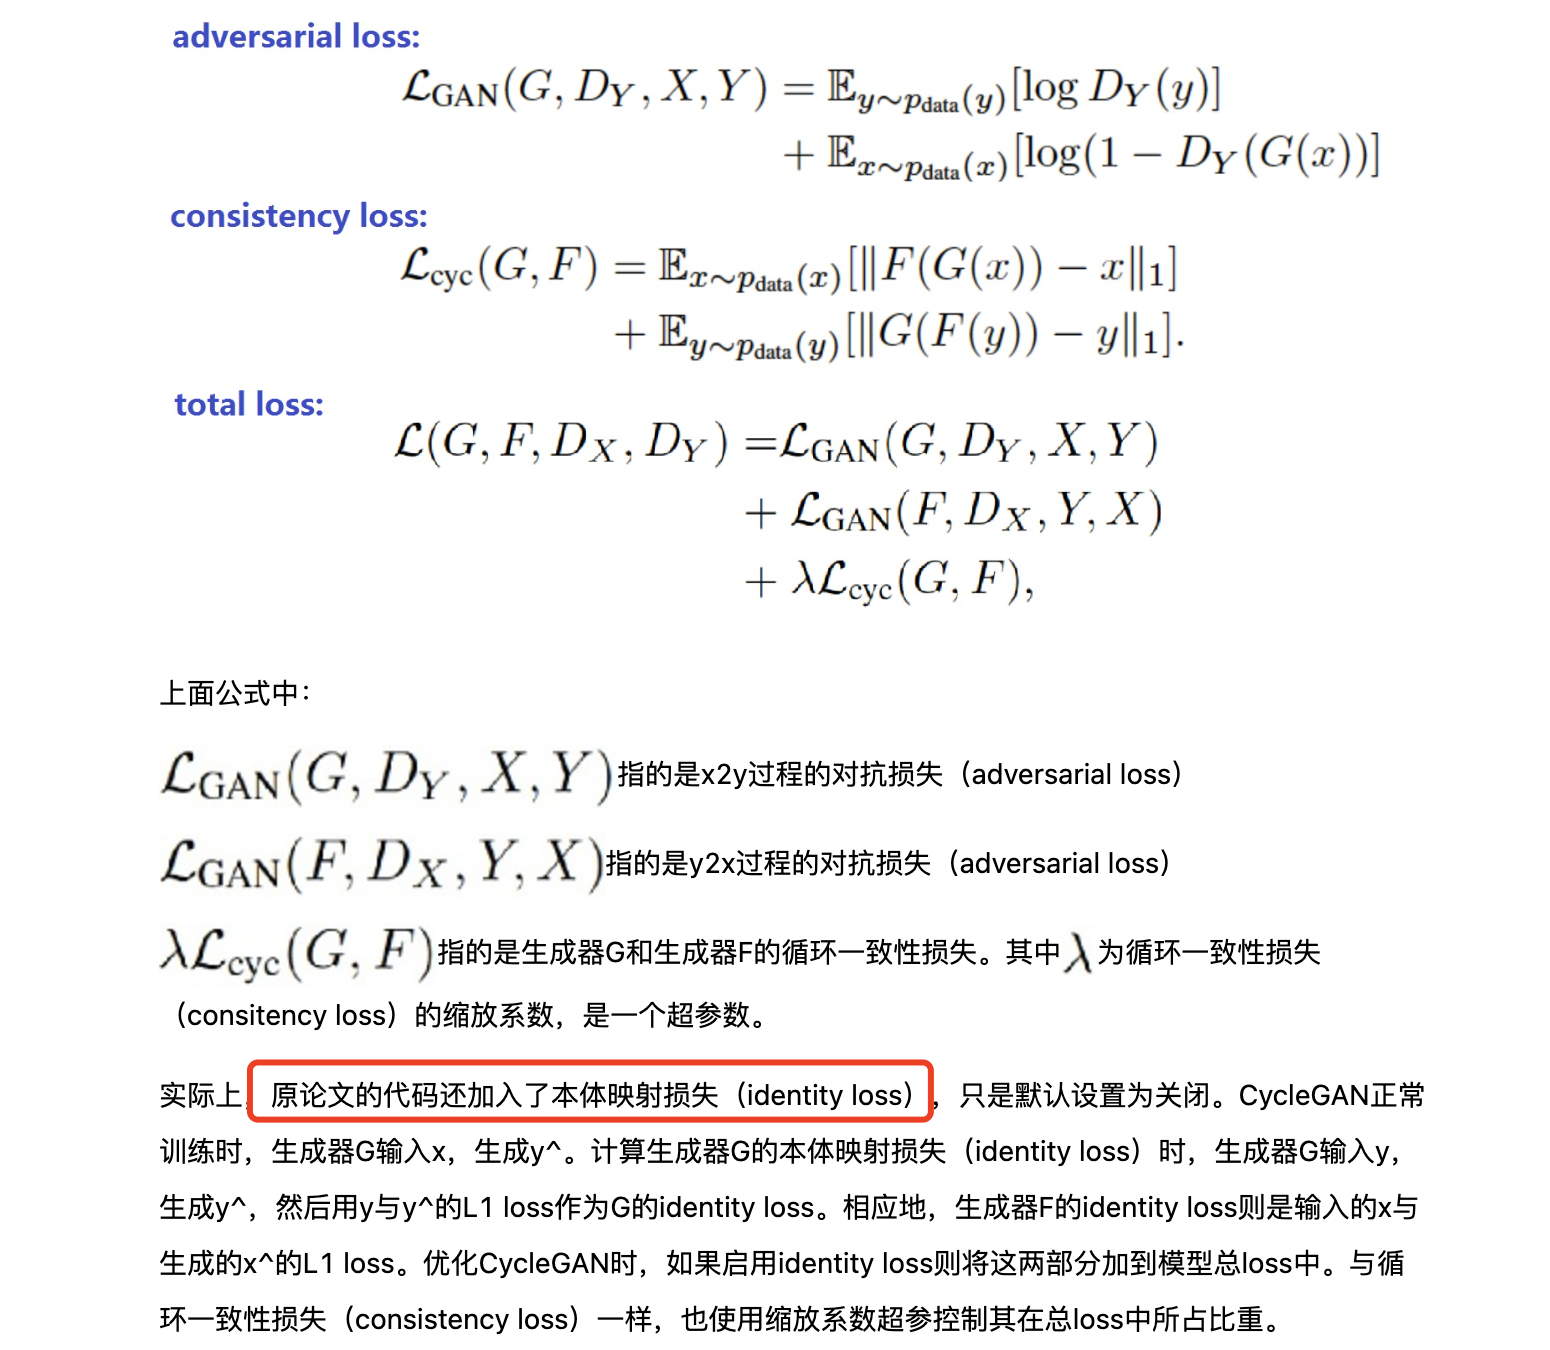

In [11]:
# 模型训练函数
def train(place, 
          epoch_num=99999, 
          adv_weight=1, 
          cycle_weight=10, 
          identity_weight=10,
          load_model=False, 
          model_path='./model/', 
          model_path_bkp='./model_bkp/',
          print_interval=1, 
          max_step=5, 
          model_bkp_interval=2000):

    # 定义两对生成器、判别器对象
    g_a = Gen()
    g_b = Gen()
    d_a = Disc()
    d_b = Disc()

    # 定义数据读取器
    dataset = H2ZDateset(DATA_DIR)
    reader_ab = DataLoader(dataset, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, num_workers=2)

    # 定义优化器
    g_a_optimizer = paddle.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameters=g_a.parameters())
    g_b_optimizer = paddle.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameters=g_b.parameters())
    d_a_optimizer = paddle.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameters=d_a.parameters())
    d_b_optimizer = paddle.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameters=d_b.parameters())

    # 定义图片缓存队列
    # fa_pool, fb_pool = ImagePool(), ImagePool()

    # 定义总迭代次数为0
    total_step_num = np.array([0])

    # 加载存储的模型
    if load_model == True:
        ga_para_dict = paddle.load(model_path+'gen_b2a.pdparams')
        g_a.set_state_dict(ga_para_dict)

        gb_para_dict = paddle.load(model_path+'gen_a2b.pdparams')
        g_b.set_state_dict(gb_para_dict)

        da_para_dict = paddle.load(model_path+'dis_ga.pdparams')
        d_a.set_state_dict(da_para_dict)

        db_para_dict = paddle.load(model_path+'dis_gb.pdparams')
        d_b.set_state_dict(db_para_dict)

        total_step_num = np.load('./model/total_step_num.npy')
    
    # 定义本次训练开始时的迭代次数
    step = total_step_num[0]

    # 开始模型训练循环
    print('Start time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'start step:', step + 1)
    for epoch in range(epoch_num):
        for data_ab in reader_ab:
            step += 1

            # 设置模型为训练模式，针对bn、dropout等进行不同处理
            g_a.train()
            g_b.train()
            d_a.train()
            d_b.train()

            # 得到A、B组图片数据
            data_ab = np.transpose(data_ab, (1, 0, 2, 3, 4))
            img_ra = paddle.to_tensor(data_ab[0])
            img_rb = paddle.to_tensor(data_ab[1])

            # 训练判别器DA (MSELoss)
            d_loss_ra = paddle.mean((d_a(img_ra) - 1) ** 2)  # least square loss
            d_loss_fa = paddle.mean((d_a(g_a(img_rb).detach()) - 0) ** 2)
            da_loss = (d_loss_ra + d_loss_fa) * 0.5
            d_a_optimizer.clear_grad() # 清除梯度
            da_loss.backward() # 反向更新梯度
            d_a_optimizer.step() # 更新模型权重

            # 训练判别器DB (MSELoss)
            d_loss_rb = paddle.mean((d_b(img_rb) - 1) ** 2)
            d_loss_fb = paddle.mean((d_b(g_b(img_ra).detach()) - 0) ** 2)
            db_loss = (d_loss_rb + d_loss_fb) * 0.5
            d_b_optimizer.clear_grad()
            db_loss.backward()
            d_b_optimizer.step()

            # 训练生成器GA
            ga_gan_loss = paddle.mean((d_a(g_a(img_rb)) - 1) ** 2)  # adversarial loss: MSELoss
            ga_cyc_loss = paddle.mean(paddle.abs(img_rb - g_b(g_a(img_rb))))  # consistency loss: L1Loss = || b - gb(ga(b)) ||
            # 论文中提到，CycleGAN 使用 identity loss 的目的是在迁移的过程中保持原色调
            ga_ide_loss = paddle.mean(paddle.abs(img_ra - g_a(img_ra))) # identity loss: L1Loss = || a - ga(a) ||
            ga_loss = ga_gan_loss * adv_weight + ga_cyc_loss * cycle_weight + ga_ide_loss * identity_weight
            g_a_optimizer.clear_grad()
            ga_loss.backward()
            g_a_optimizer.step()

            # 训练生成器GB
            gb_gan_loss = paddle.mean((d_b(g_b(img_ra)) - 1) ** 2)
            gb_cyc_loss = paddle.mean(paddle.abs(img_ra - g_a(g_b(img_ra))))
            gb_ide_loss = paddle.mean(paddle.abs(img_rb - g_b(img_rb)))
            gb_loss = gb_gan_loss * adv_weight + gb_cyc_loss * cycle_weight + gb_ide_loss * identity_weight
            g_b_optimizer.clear_grad()
            gb_loss.backward()
            g_b_optimizer.step()
            
            # 存储训练过程中生成的图片
            if step in range(1, 101):
                pic_save_interval = 1
            elif step in range(101, 1001):
                pic_save_interval = 10
            elif step in range(1001, 10001):
                pic_save_interval = 100
            else:
                pic_save_interval = 500
            if step % pic_save_interval == 0:
                save_pics([img_ra.numpy(), g_b(img_ra).numpy(), g_a(g_b(img_ra)).numpy(), g_b(img_rb).numpy(), \
                            img_rb.numpy(), g_a(img_rb).numpy(), g_b(g_a(img_rb)).numpy(), g_a(img_ra).numpy()], \
                            str(step))
                test_pic = open_pic()
                test_pic_pp = paddle.to_tensor(test_pic)
                save_pics([test_pic, g_b(test_pic_pp).numpy()], str(step), save_path='./output/pics_test/')

            # 打印训练过程中的loss值和生成的图片
            if step % print_interval == 0:
                print([step], \
                        'DA:', da_loss.numpy(), d_loss_ra.numpy(), d_loss_fa.numpy(), \
                        'DB:', db_loss.numpy(), d_loss_rb.numpy(), d_loss_fb.numpy(), \
                        'GA:', ga_loss.numpy(), \
                        'GB:', gb_loss.numpy(), \
                        time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
                print("[real a]\t[gen b from real a]\t[gen a from gen b from real a]\t[gen b from real b]")
                show_pics([img_ra.numpy(), g_b(img_ra).numpy(), g_a(g_b(img_ra)).numpy(), g_b(img_rb).numpy()])
                print("[real b]\t[gen a from real b]\t[gen b from gen a from real b]\t[gen  a from real a]")
                show_pics([img_rb.numpy(), g_a(img_rb).numpy(), g_b(g_a(img_rb)).numpy(), g_a(img_ra).numpy()])

            # 定期备份模型
            if step % model_bkp_interval == 0:
                paddle.save(g_a.state_dict(), model_path_bkp+'gen_b2a.pdparams')
                paddle.save(g_b.state_dict(), model_path_bkp+'gen_a2b.pdparams')
                paddle.save(d_a.state_dict(), model_path_bkp+'dis_ga.pdparams')
                paddle.save(d_b.state_dict(), model_path_bkp+'dis_gb.pdparams')
                np.save(model_path_bkp+'total_step_num', np.array([step]))

            # 完成训练时存储模型
            if step >= max_step + total_step_num[0]:
                paddle.save(g_a.state_dict(), model_path+'gen_b2a.pdparams')
                paddle.save(g_b.state_dict(), model_path+'gen_a2b.pdparams')
                paddle.save(d_a.state_dict(), model_path+'dis_ga.pdparams')
                paddle.save(d_b.state_dict(), model_path+'dis_gb.pdparams')
                np.save(model_path+'total_step_num', np.array([step]))
                print('End time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'End Step:', step)
                return

Start time : 2022-05-04 17:45:38 start step: 200201
[200210] DA: [0.10305162] [0.03914666] [0.16695657] DB: [0.05443317] [0.06668812] [0.04217822] GA: [2.9525065] GB: [2.7571185] 2022-05-04 17:45:41
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


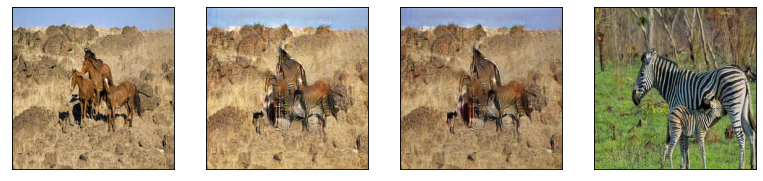

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


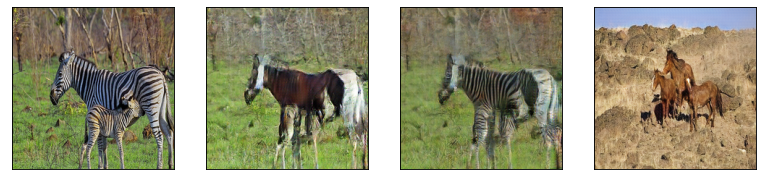

[200220] DA: [0.07222077] [0.05028109] [0.09416046] DB: [0.08986666] [0.10013685] [0.07959647] GA: [2.7980638] GB: [2.9744997] 2022-05-04 17:45:43
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


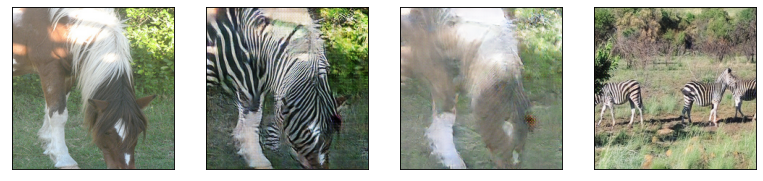

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


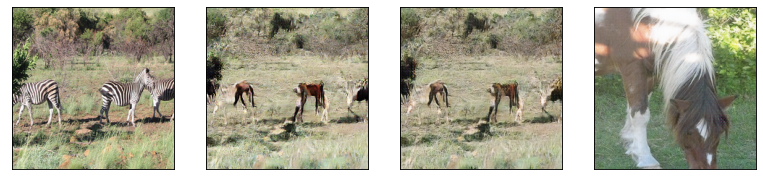

[200230] DA: [0.0457251] [0.03668631] [0.05476389] DB: [0.08613011] [0.13105758] [0.04120264] GA: [3.1350281] GB: [2.1920023] 2022-05-04 17:45:46
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


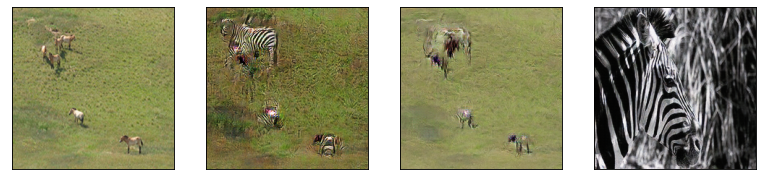

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


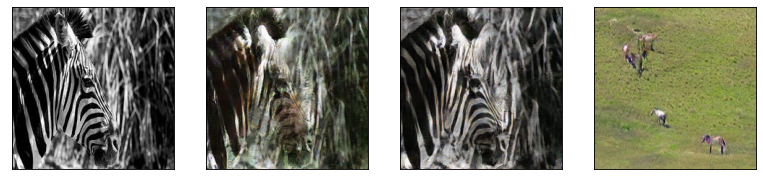

[200240] DA: [0.05262349] [0.02791473] [0.07733225] DB: [0.06522104] [0.03738387] [0.09305821] GA: [2.3681846] GB: [2.455396] 2022-05-04 17:45:48
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


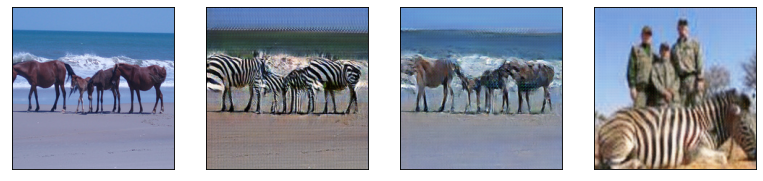

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


[200250] DA: [0.08432962] [0.03967128] [0.12898797] DB: [0.10092867] [0.06588291] [0.13597444] GA: [3.099884] GB: [2.6141486] 2022-05-04 17:45:51
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


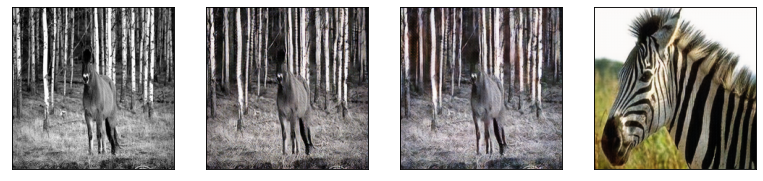

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


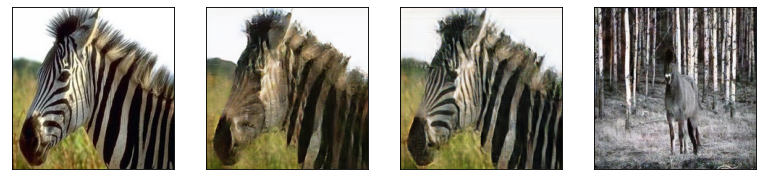

[200260] DA: [0.0719966] [0.05003175] [0.09396145] DB: [0.04948616] [0.04919405] [0.04977826] GA: [2.862211] GB: [3.2523685] 2022-05-04 17:45:54
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


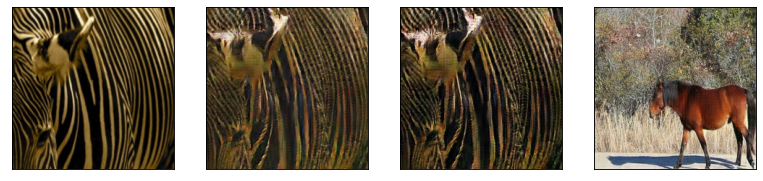

[200270] DA: [0.09625765] [0.09415261] [0.09836269] DB: [0.13331749] [0.15780628] [0.10882869] GA: [2.5926154] GB: [2.4170883] 2022-05-04 17:45:56
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


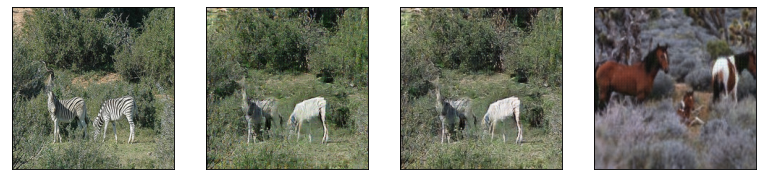

[200280] DA: [0.06768419] [0.06466737] [0.070701] DB: [0.04017412] [0.04393513] [0.03641311] GA: [2.8825107] GB: [2.5909119] 2022-05-04 17:45:59
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


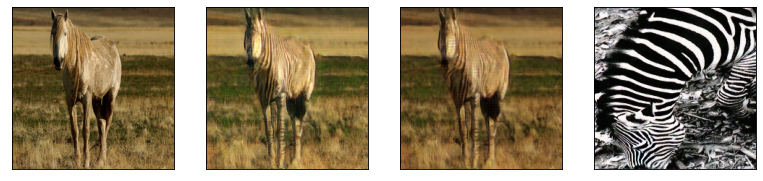

[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


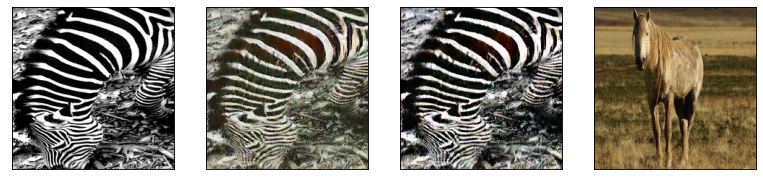

[200290] DA: [0.06307402] [0.08801057] [0.03813748] DB: [0.08180261] [0.05213979] [0.11146544] GA: [2.567685] GB: [2.2207003] 2022-05-04 17:46:01
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


[200300] DA: [0.07361314] [0.08907782] [0.05814845] DB: [0.12234952] [0.0459514] [0.19874763] GA: [2.4656339] GB: [2.594249] 2022-05-04 17:46:04
[real a]	[gen b from real a]	[gen a from gen b from real a]	[gen b from real b]


[real b]	[gen a from real b]	[gen b from gen a from real b]	[gen  a from real a]


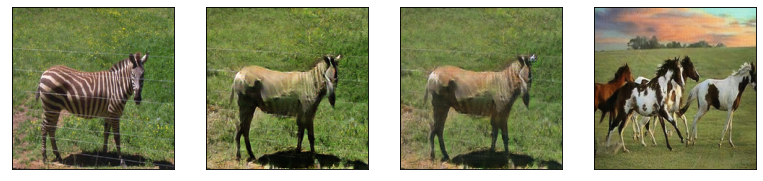

End time : 2022-05-04 17:46:05 End Step: 200300


In [55]:
# 从头训练
#train(PLACE, print_interval=10000, max_step=200000)

# 继续训练
train(PLACE, print_interval=10, max_step=100, load_model=True)

# Inference

In [12]:
def infer(img_path, place, model_path='./model/'):
    # 定义生成器对象
    g_b = Gen()

    # 设置模型为训练模式，针对bn、dropout等进行不同处理
    g_b.eval()

    # 读取存储的模型
    gb_para_dict = paddle.load(model_path+'gen_a2b.pdparams')
    g_b.set_state_dict(gb_para_dict)
    
    # 读取图片数据
    img_a = cv2.imread(img_path)
    img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
    img_a = data_transform(img_a, 224)
    img_a = paddle.to_tensor(np.array([img_a]))
    
    # 正向计算进行推理
    img_b = g_b(img_a)

    # 打印输出输入、输出图片
    print(img_a.numpy().shape, img_a.numpy().dtype)
    show_pics([img_a.numpy(), img_b.numpy()])


testA/n02381460_6920.jpg
(1, 3, 224, 224) float32


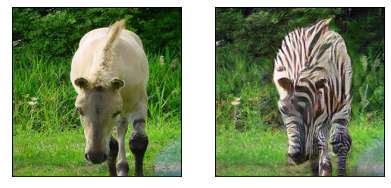

In [13]:
test_img = str(np.random.choice(np.loadtxt('./data/horse2zebra/testA.txt', dtype=np.str)))
print(test_img)
infer(f'./data/horse2zebra/{test_img}', PLACE)